# Wikipedia

This notebook shows how to apply [scikit-network](https://scikit-network.readthedocs.io/) to analyse the network structure of Wikipedia, through its hyperlinks.

We consider the [Wikivitals](https://netset.telecom-paris.fr/pages/wikivitals.html) dataset of the [netset](https://netset.telecom-paris.fr) collection. This dataset consists of the (approximately) [top 10,000 (vital) articles of Wikipedia](https://fr.wikipedia.org/wiki/Wikipédia:Articles_vitaux/Niveau_4).

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy.cluster.hierarchy import linkage

In [3]:
from sknetwork.data import load_netset
from sknetwork.ranking import PageRank, top_k
from sknetwork.embedding import Spectral
from sknetwork.clustering import Louvain
from sknetwork.classification import DiffusionClassifier
from sknetwork.utils import get_neighbors
from sknetwork.visualization import svg_dendrogram

## Data

All datasets of the [netset](https://netset.telecom-paris.fr) collection can be easily imported with scikit-network.

In [4]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [5]:
# graph of links
adjacency = wikivitals.adjacency
names = wikivitals.names
labels = wikivitals.labels
names_labels = wikivitals.names_labels

In [6]:
adjacency

<10011x10011 sparse matrix of type '<class 'numpy.bool_'>'
	with 824999 stored elements in Compressed Sparse Row format>

In [7]:
# categories
print(names_labels)

['Arts' 'Biological and health sciences' 'Everyday life' 'Geography'
 'History' 'Mathematics' 'People' 'Philosophy and religion'
 'Physical sciences' 'Society and social sciences' 'Technology']


In [8]:
# get label
label_id = {name: i for i, name in enumerate(names_labels)}

## Sample

Let's have a look at an article.

In [17]:
i = 10000
print(names[i])

Édouard Manet


In [18]:
# label
label = labels[i]
print(names_labels[label])

People


In [19]:
# some hyperlinks
neighbors = get_neighbors(adjacency, i)
print(names[neighbors[:10]])

['Adolphe Thiers' 'American Civil War' 'Bordeaux' 'Camille Pissarro'
 'Carmen' 'Charles Baudelaire' 'Claude Monet' 'Diego Velázquez'
 'Edgar Allan Poe' 'Edgar Degas']


In [20]:
len(neighbors)

38

## PageRank

We first use (personalized) [PageRank](https://en.wikipedia.org/wiki/PageRank) to select typical articles of each category.

In [13]:
pagerank = PageRank()

In [14]:
# number of articles per category
n_selection = 50

In [15]:
# selection of articles
selection = []
for label in np.arange(len(names_labels)):
    ppr = pagerank.fit_predict(adjacency, weights=(labels==label))
    scores = ppr * (labels==label)
    selection.append(top_k(scores, n_selection))
selection = np.array(selection)

In [16]:
selection.shape

(11, 50)

In [17]:
# show selection
for label, name_label in enumerate(names_labels):
    print('---')
    print(label, name_label)
    print(names[selection[label, :5]])

---
0 Arts
['Encyclopædia Britannica' 'Romanticism' 'Jazz' 'Modernism' 'Baroque']
---
1 Biological and health sciences
['Taxonomy (biology)' 'Animal' 'Chordate' 'Plant' 'Species']
---
2 Everyday life
['Olympic Games' 'Association football' 'Basketball' 'Baseball' 'Softball']
---
3 Geography
['Geographic coordinate system' 'United States' 'China' 'France' 'India']
---
4 History
['World War II' 'World War I' 'Roman Empire' 'Ottoman Empire'
 'Middle Ages']
---
5 Mathematics
['Real number' 'Function (mathematics)' 'Complex number'
 'Set (mathematics)' 'Integer']
---
6 People
['Aristotle' 'Plato' 'Augustine of Hippo' 'Winston Churchill'
 'Thomas Aquinas']
---
7 Philosophy and religion
['Christianity' 'Islam' 'Buddhism' 'Hinduism' 'Catholic Church']
---
8 Physical sciences
['Oxygen' 'Hydrogen' 'Earth' 'Kelvin' 'Density']
---
9 Society and social sciences
['The New York Times' 'Latin' 'English language' 'French language'
 'United Nations']
---
10 Technology
['NASA' 'Internet' 'Operating syste

## Embedding

We now represent each node of the graph by a vector in low dimension, and use hierarchical clustering to visualize the structure of this embedding.

In [18]:
# dimension of the embedding
n_components = 20

In [19]:
# embedding
spectral = Spectral(n_components)
embedding = spectral.fit_transform(adjacency)

In [20]:
embedding.shape

(10011, 20)

In [22]:
# hierarchy of articles
label = label_id['Physical sciences']
index = selection[label]
dendrogram_articles = linkage(embedding[index], method='ward')

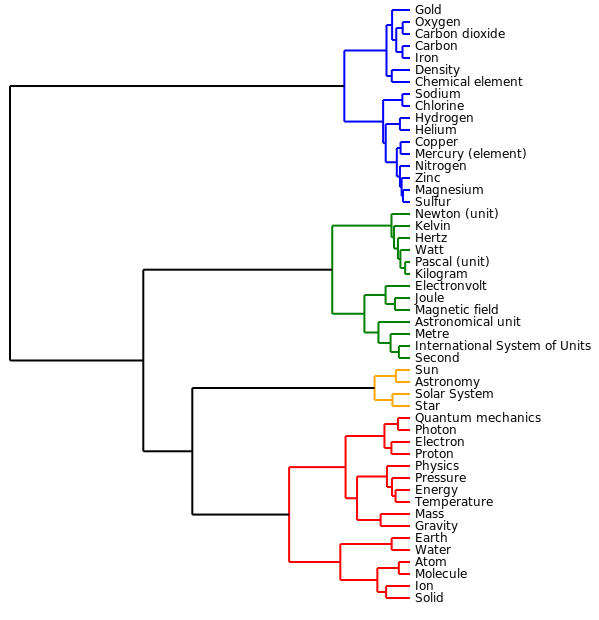

In [23]:
# visualization
image = svg_dendrogram(dendrogram_articles, names=names[index], rotate=True, width=200, scale=2, n_clusters=4)
SVG(image)

## Clustering

We now apply Louvain to get a clustering of the graph, independently of the known labels.

In [24]:
algo = Louvain()

In [25]:
labels_pred = algo.fit_predict(adjacency)

In [26]:
np.unique(labels_pred, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([1800, 1368, 1315, 1225, 1165, 1067,  804,  672,  468,   97,   30]))

We use again PageRank to get the top pages of each cluster.

In [27]:
n_selection = 5

In [28]:
selection = []
for label in np.arange(len(set(labels_pred))):
    ppr = pagerank.fit_predict(adjacency, weights=(labels_pred==label))
    scores = ppr * (labels_pred==label)
    selection.append(top_k(scores, n_selection))
selection = np.array(selection)

In [29]:
# show selection
for label in np.arange(len(set(labels_pred))):
    print('---')
    print(label)
    print(names[selection[label]])

---
0
['Taxonomy (biology)' 'Animal' 'Plant' 'Protein' 'Species']
---
1
['Hydrogen' 'Oxygen' 'Kelvin' 'Electron' 'Physics']
---
2
['Latin' 'World War I' 'Roman Empire' 'Middle Ages' 'Greek language']
---
3
['United States' 'World War II' 'Geographic coordinate system'
 'United Kingdom' 'France']
---
4
['Christianity' 'Aristotle' 'Plato' 'Catholic Church'
 'Age of Enlightenment']
---
5
['China' 'India' 'Buddhism' 'Islam' 'Chinese language']
---
6
['The New York Times' 'New York City' 'Time (magazine)' 'BBC'
 'The Washington Post']
---
7
['Earth' 'Atlantic Ocean' 'Europe' 'Drainage basin' 'Pacific Ocean']
---
8
['Real number' 'Function (mathematics)' 'Complex number'
 'Set (mathematics)' 'Mathematical analysis']
---
9
['Marriage' 'Incest' 'Adoption' 'Kinship' 'Human sexuality']
---
10
['Handbag' 'Hat' 'Veil' 'Uniform' 'Clothing']


## Classification

Finally, we use heat diffusion to predict the closest category for each page in the People category.

In [30]:
algo = DiffusionClassifier()

In [31]:
people = label_id['People']

In [32]:
labels_people = algo.fit_predict(adjacency, labels = {i: label for i, label in enumerate(labels) if label != people})

In [33]:
n_selection = 5

In [34]:
selection = []
for label in np.arange(len(names_labels)):
    if label != people:
        ppr = pagerank.fit_predict(adjacency, weights=(labels==people)*(labels_people==label))
        scores = ppr * (labels==people)*(labels_people==label)
        selection.append(top_k(scores, n_selection))
selection = np.array(selection)

In [35]:
# show selection
i = 0
for label, name_label in enumerate(names_labels):
    if label != people:
        print('---')
        print(label, name_label)
        print(names[selection[i]])
        i += 1


---
0 Arts
['Richard Wagner' 'Igor Stravinsky' 'Bob Dylan' 'Fred Astaire'
 'Ludwig van Beethoven']
---
1 Biological and health sciences
['Charles Darwin' 'Francis Crick' 'Robert Koch' 'Alexander Fleming'
 'Carl Linnaeus']
---
2 Everyday life
['Wayne Gretzky' 'Jim Thorpe' 'Jackie Robinson' 'LeBron James'
 'Willie Mays']
---
3 Geography
['Elizabeth II' 'Carl Lewis' 'Dwight D. Eisenhower' 'Vladimir Putin'
 'Muhammad Ali']
---
4 History
['Alexander the Great' 'Napoleon' 'Charlemagne' 'Philip II of Spain'
 'Charles V, Holy Roman Emperor']
---
5 Mathematics
['Euclid' 'Augustin-Louis Cauchy' 'Archimedes' 'John von Neumann'
 'Pierre de Fermat']
---
7 Philosophy and religion
['Augustine of Hippo' 'Aristotle' 'Thomas Aquinas' 'Plato' 'Immanuel Kant']
---
8 Physical sciences
['Albert Einstein' 'Isaac Newton' 'J. J. Thomson' 'Marie Curie'
 'Niels Bohr']
---
9 Society and social sciences
['Barack Obama' 'Noam Chomsky' 'Karl Marx' 'Ralph Waldo Emerson'
 'Jean-Paul Sartre']
---
10 Technology
['Tim Be